In [ ]:
import pandas as pd
import keras
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
import sklearn.model_selection
from sklearn.model_selection import cross_val_score, KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate as CV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import statistics
import os
# !pip install scikeras
# from scikeras.wrappers import KerasRegressor

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
keras.backend.set_epsilon(1)

try:
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  IN_COLAB = True
except:
  IN_COLAB = False




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if IN_COLAB == True:
  df_monthly0 = pd.read_csv('/content/drive/Shareddrives/RHESSys ML Capstone/lstm/data/df_monthly0.csv')
else:
  df_monthly0 = pd.read_csv('df_monthly0.csv')

npp0 = df_monthly0['npp']
npp0 = npp0.values.reshape(-1, 1)
df_monthly0_pred = df_monthly0.drop(columns=['scen', 'topo', 'npp'])
monthly0_pred = df_monthly0_pred.values.reshape(len(df_monthly0_pred), len(df_monthly0_pred.columns))



In [ ]:
monthly0_pred.shape

(19440, 17)

In [ ]:
# split into training and test sets
test_size = 0.2
train_size = 1 - test_size

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(npp0)
npp0 = scaler.transform(npp0)

scaler.fit(monthly0_pred)
monthly0 = scaler.transform(monthly0_pred)

monthly0_train_pred, monthly0_test_pred = sklearn.model_selection.train_test_split(monthly0, test_size=test_size)
npp0_train, npp0_test = sklearn.model_selection.train_test_split(npp0, test_size=test_size)

# reshape predictor variables
monthly0_train_pred = monthly0_train_pred.reshape((len(monthly0_train_pred), 1, 17))
monthly0_test_pred = monthly0_test_pred.reshape((len(monthly0_test_pred), 1, 17))

In [ ]:
print(monthly0_train_pred.shape)
print(npp0_train.shape)

(15552, 1, 17)
(15552, 1)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model = Sequential()
model.add(LSTM(8, input_shape=(monthly0_train_pred.shape[1], monthly0_train_pred.shape[2]), return_sequences=True))
# model.add(LSTM(12))
model.add(Dense(8))
model.add(Dense(4))
model.add(Dense(1))

model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [ ]:
history = model.fit(monthly0_train_pred, npp0_train, epochs=12,
 batch_size=24, validation_data=(monthly0_test_pred, npp0_test), verbose=1)


Epoch 1/12
648/648 [==============================] - 5s 4ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/12
648/648 [==============================] - 2s 3ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 3/12
648/648 [==============================] - 2s 3ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 4/12
648/648 [==============================] - 2s 3ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 5/12
648/648 [==============================] - 2s 3ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 6/12
648/648 [==============================] - 2s 3ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 7/12
648/648 [==============================] - 2s 3ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 8/12
648/648 [==============================] - 2s 3ms/step - loss: 0.

In [ ]:
history.history['val_mse']

[0.01609533652663231,
 0.009256032295525074,
 0.007327558007091284,
 0.0065243300050497055,
 0.006192987784743309,
 0.00602923147380352,
 0.0060751973651349545,
 0.006175519898533821,
 0.006068916525691748,
 0.005987121723592281,
 0.005975231062620878,
 0.005980682093650103]

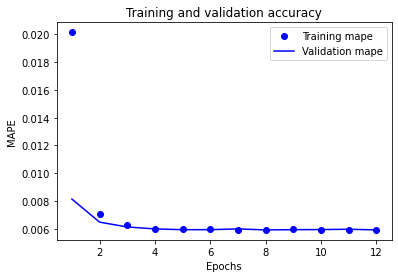

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['mse']
val_acc = history.history['val_mse']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training mape')
plt.plot(epochs, val_acc, 'b', label='Validation mape')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

## Grid search optimization

In [ ]:
def create_model(learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(12, input_shape=(monthly0_train_pred.shape[1], monthly0_train_pred.shape[2])))
    model.add(Dense(6))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['mse'])
    return model

model = KerasRegressor(build_fn=create_model, epochs=8, batch_size=12, verbose=0, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == '__main__':


In [ ]:
batch_size = [12, 24, 36]
epochs = [6, 8, 10]
learning_rate = [0.1, 0.01, 0.001]
# scoring in this method is always maximized, so metrics that require minimization are made negative
scoring = 'neg_mean_squared_error'
param_grid = dict(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring=scoring)
grid_result = grid.fit(monthly0_train_pred, npp0_train)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.005973 using {'batch_size': 36, 'epochs': 6, 'learning_rate': 0.01}
-0.007138 (0.000951) with: {'batch_size': 12, 'epochs': 6, 'learning_rate': 0.1}
-0.006060 (0.000081) with: {'batch_size': 12, 'epochs': 6, 'learning_rate': 0.01}
-0.006193 (0.000095) with: {'batch_size': 12, 'epochs': 6, 'learning_rate': 0.001}
-0.006572 (0.000763) with: {'batch_size': 12, 'epochs': 8, 'learning_rate': 0.1}
-0.005998 (0.000086) with: {'batch_size': 12, 'epochs': 8, 'learning_rate': 0.01}
-0.006065 (0.000030) with: {'batch_size': 12, 'epochs': 8, 'learning_rate': 0.001}
-0.007894 (0.002360) with: {'batch_size': 12, 'epochs': 10, 'learning_rate': 0.1}
-0.005998 (0.000140) with: {'batch_size': 12, 'epochs': 10, 'learning_rate': 0.01}
-0.006094 (0.000208) with: {'batch_size': 12, 'epochs': 10, 'learning_rate': 0.001}
-0.006250 (0.000417) with: {'batch_size': 24, 'epochs': 6, 'learning_rate': 0.1}
-0.006098 (0.000132) with: {'batch_size': 24, 'epochs': 6, 'learning_rate': 0.01}
-0.006017 (0.000120

In [ ]:
# Save grid search results to csv
import joblib
from datetime import datetime

df = pd.DataFrame(grid_result.cv_results_)
df = df[['mean_test_score', 'param_batch_size', 'param_epochs', 'param_learning_rate',]]
now = datetime.now()
timestamp = now.strftime('%m-%d--%H:%M')
filename = '/content/drive/Shareddrives/RHESSys ML Capstone/lstm/grid_searches/lstm_grid_search_' + timestamp + '.csv'

df.to_csv(filename)

In [ ]:
# sorted(sklearn.metrics.SCORERS.keys())
# KerasRegressor().get_params().keys()